[ROFORMER: ENHANCED TRANSFORMER WITH ROTARY POSITION EMBEDDING](https://arxiv.org/pdf/2104.09864.pdf)

假设 q 和 k 是只有两维的向量，Attention 里面核心的操作是求 qk 的内积 $<\bf{q},\bf{k}>$

In [1]:
def dot(a, b):
  return sum(i*j for i, j in zip(a, b))

q = [0.1, 0.3]
k = [0.2, 0.4]
print(f"{q=}")
print(f"{k=}")
print(f"{dot(q,k)=}")

q=[0.1, 0.3]
k=[0.2, 0.4]
dot(q,k)=0.14


将 q k 分别看成复数（第一维对应实部，第二维对应虚部）q_c 和 k_c，则 qk 的内积等于 q_c 与 k_c 的共轭复数乘积的实部
$$
<\bf{q}, \bf{k}> = Re[\bf{q_c}\bf{k_c}^{*}]
$$

推导

$$\bf{q_c} = q_0 + q_1 i$$
$$\bf{k_c}^{*} = k_0 - k_1 i$$
$$\bf{q_c}\bf{k_c}^{*} = q_0 k_0 + q_1 k_1 + (q_1 k_0 - q_0 k_1)i$$

其实部 $q_0 k_0 + q_1 k_1$ 即为 q k 的内积


In [2]:
import cmath

q_c = complex(q[0], q[1])
k_c = complex(k[0], k[1])
print(f"{q_c=}")
print(f"{k_c=}")
print(f"Re[q_c*k_c'] = {(q_c * k_c.conjugate()).real}")

q_c=(0.1+0.3j)
k_c=(0.2+0.4j)
Re[q_c*k_c'] = 0.13999999999999999


### 旋转复数

假设 q k 对应的位置分别为 m, n，将复数 $\bf{q_c}, \bf{k_c}$ 乘上 $e^{im\theta}, e^{in\theta}$

- 从位置编码的角度，这一步是将 q k 各自的绝对位置信息加入到编码中
- 从复数的角度看，乘上这个复数在复平面上的效果相当于将复平面上的向量分别旋转 $m\theta$ 和 $n\theta$

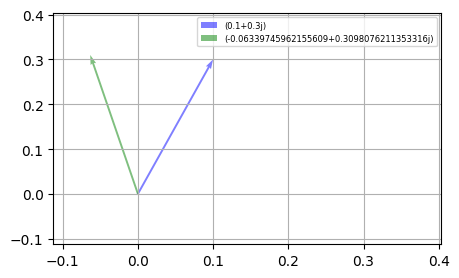

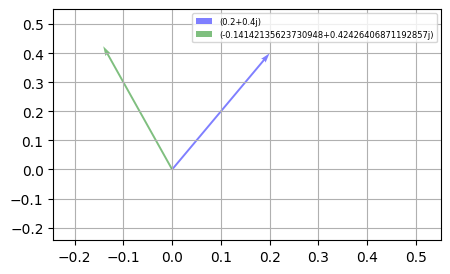

In [3]:
import math

m_theta = 30/180*math.pi  # 30 degrees
n_theta = 45/180*math.pi  # 45 degrees

q_c_rotated = q_c * math.e**complex(0, m_theta)
k_c_rotated = k_c * math.e**complex(0, n_theta)

import matplotlib.pyplot as plt
def plot_complex(xs:list[complex]):
  """helper function to visualize complex numbers in complex plan"""
  plt.figure(figsize=(5, 3))
  plt.grid()
  # proper scaling
  val_x_axis = [0] + [x.real for x in xs]
  val_y_axis = [0] + [x.imag for x in xs]
  delta_x_axis = max(val_x_axis) - min(val_x_axis) 
  delta_y_axis = max(val_y_axis) - min(val_y_axis) 
  min_ = min(min(val_x_axis) - 0.3*delta_x_axis, min(val_y_axis) - 0.3*delta_y_axis)
  max_ = max(max(val_x_axis) + 0.3*delta_x_axis, max(val_y_axis) + 0.3*delta_y_axis)
  plt.xlim(min_, max_)
  plt.ylim(min_, max_)
  
  colors = "bgrcmykw"
  for i, x in enumerate(xs):
    c = colors[i % len(colors)]
    plt.quiver(0, 0, x.real, x.imag, angles="xy", scale_units="xy", scale=1, color=c, alpha=0.5, width=0.005, label=str(x))
  plt.legend(fontsize="6")
  plt.show()
  
plot_complex([q_c, q_c_rotated])
plot_complex([k_c, k_c_rotated])

### WHY

重新计算经过旋转之后的复数对应的向量（记为 $q'$ 和 $k'$）的内积
$$<q',k'> = Re[(\bf{q_c} e^{im\theta})(\bf{k_c} e^{in\theta})^{*}] = Re[\bf{q_c}\bf{k_c}^{*} e^{i(m-n)\theta}]$$

可以看到经过旋转后的向量的内积里出现了q和k的相对位置信息 m-n，这个正是我们希望的。

换句话说，**RoPE 通过对 q 和 k 以一种巧妙的形式引入绝对位置信息，使得他们的内积带上了相对位置信息。**

从上式我们可以看出旋转后的内积是关于 m-n 的一个函数，可以进一步展开看看就是是一个什么样的函数

首先

$$
\bf{q_c}\bf{k_c}^{*} = (q_0 k_0 + q_1 k_1) + (q_1 k_0 - q_0 k_1)i
$$

欧拉公式可得

$$
e^{i(m-n)\theta} = \cos{\{(m-n)\theta\}} + \sin{\{(m-n)\theta\}}i
$$

计算可得

$$
Re[\bf{q_c}\bf{k_c}^{*} e^{i(m-n)\theta}] = (q_0 k_0 + q_1 k_1)\cos{\{(m-n)\theta\}} - (q_1 k_0 - q_0 k_1)\sin{\{(m-n)\theta\}}
$$

### Rotation Matric

复数 $\bf{q_c}, \bf{k_c}$ 乘上 $e^{im\theta}, e^{in\theta}$ 向量空间是旋转，可以写成矩阵相乘的形式

$$
\begin{bmatrix}
\cos{m\theta} & -\sin{m\theta} \\
\sin{m\theta} & \cos{m\theta} 
\end{bmatrix}
$$

In [4]:
import numpy as np

rotation_matric = np.array([
  [np.cos(m_theta), -np.sin(m_theta)],
  [np.sin(m_theta), np.cos(m_theta)],
])
print(complex(*(rotation_matric @ np.array(q))))
print(q_c_rotated)

(-0.0633974596215561+0.3098076211353316j)
(-0.06339745962155609+0.3098076211353316j)


#### 扩展到多维

内积满足线性叠加性，因此任意偶数维的 q k，我们都可以表示为二维情形的拼接（线性叠加性指高维 qk 的内积等于多个二维 qk 内积相加，通过这样拆组->旋转->拼接后的 qk 内积仍是 m-n 的函数）

In [5]:
D = 128
q = np.random.uniform(0, 1, D)
k = np.random.uniform(0, 1, D)

In [6]:
# suppose current position of q is 16

i = 16
rotation_matrix = np.zeros((D, D))
for j in range(D//2):
  theta = 10000**(2*j/D)
  rotation_matrix[2*j, 2*j] = np.cos(i / theta)
  rotation_matrix[2*j, 2*j+1] = -np.sin(i / theta)
  rotation_matrix[2*j+1, 2*j] = np.sin(i / theta)
  rotation_matrix[2*j+1, 2*j+1] = np.cos(i / theta)
  
rotation_matrix @ q

array([-0.19349398, -0.59900659, -0.00220588,  0.99207776,  1.20420459,
        0.19889481,  0.28585803, -0.29674704, -0.41052336, -0.2205918 ,
       -0.26827859,  0.91732036, -0.08298787,  0.93666384,  0.8732139 ,
        0.06282934,  0.55610666, -0.21574871,  0.51457989, -0.93824975,
       -0.03275912, -1.0976248 , -0.22398886, -0.12227225, -0.6654316 ,
       -0.03776744, -0.74782258, -0.42697587, -0.52925013,  0.22149293,
       -0.09007745,  0.12238481, -0.22687301,  0.21541225, -0.63990699,
        0.72431336, -0.26121273,  0.41164175, -0.53012292,  0.43243289,
       -0.29069824,  0.65545779, -0.19701178,  0.4815289 , -0.40773076,
        0.59250694,  0.52319893,  1.00347288,  0.43460467,  1.14266937,
        0.30130249,  0.28281661,  0.06624857,  1.00391439,  0.6731183 ,
        0.72208217,  0.49093531,  1.0977266 ,  0.72420182,  0.51769072,
        0.87104826,  0.2367282 ,  0.3786721 ,  1.01494916, -0.01084651,
        0.97868845, -0.10555446,  0.94086145,  0.89735541,  0.12

旋转矩阵是稀疏的，直接使用矩阵乘法比较低效，可以使用点乘来更高效的实现

In [7]:
def rope(x, i):
  x_ = np.flip(np.reshape(x, (-1, 2)), axis=-1).copy()
  x_[:, 0] *= -1
  x_ = np.reshape(x_, -1)
  pos = np.arange(1, D//2+1).repeat(2)
  theta = 1/(10000**(2*(pos-1)/D))
  return x * np.cos(i * theta) + x_ * np.sin(i * theta)

In [8]:
np.allclose(rope(q, 16), rotation_matrix @ q)

True

#### RoPE 性质
1. qk 向量不变，保持相对位置不变，仅改变绝对位置，qk 内积的也保持不变（qk内积仅与 qk 本身以及相对位置 m-n 相关）
2. 远程衰减性：随着 qk 相对位置的拉大，qk 内积会变小

In [9]:
print("<q,k> when m=10, n=20: ", dot(rope(q, 10), rope(k, 20)))
print("<q,k> when m=20, n=30: ", dot(rope(q, 20), rope(k, 30)))

<q,k> when m=10, n=20:  22.93861356261944
<q,k> when m=20, n=30:  22.938613562619437


In [10]:
print("<q,k> when m-n=10: ", dot(rope(q, 20), rope(k, 10)))
print("<q,k> when m-n=20: ", dot(rope(q, 30), rope(k, 10)))

<q,k> when m-n=10:  21.957862198727057
<q,k> when m-n=20:  20.11621783431844


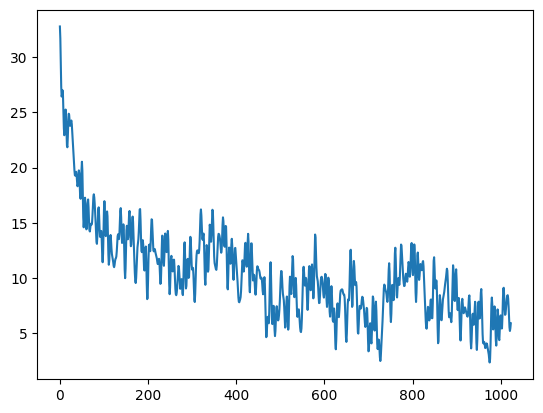

In [11]:
N = 1024
plt.plot(range(N), [dot(rope(q, 0), rope(k, i)) for i in range(N)])
plt.show()